In [1]:
idl_wxy_file = '/Users/dperera/test_data/paper/F0310_FI_IFS_7500161_BLU_WXY_200005-200239_idl_fwhm6.2.fits'
py_wxy_file = '/Users/dperera/test_data/paper/F0310_FI_IFS_7500161_BLU_WXY_200005-200239_python_1.24arcsec.fits'

In [2]:
import pickle
import numpy as np
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma
import matplotlib.pyplot as plt
from sofia_redux.toolkit.resampling.resample import Resample
import warnings
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

standard_data_file = '/Users/dperera/test_data/fifi-ls/standard_30dor.p'
shaped_data_file = '/Users/dperera/test_data/fifi-ls/shaped_30dor.p'
standard_data = pickle.load(open(standard_data_file, "rb" ))

w_fwhm = 0.056389
xy_fwhm = 6.2
w_sigma = w_fwhm * gaussian_fwhm_to_sigma
xy_sigma = xy_fwhm * gaussian_fwhm_to_sigma
fwhms = np.array([xy_fwhm, xy_fwhm, w_fwhm])


In [407]:
coordinates = standard_data['coordinates'].copy()
data = standard_data['data'].copy()
grid = standard_data['grid']
error = standard_data['error'].copy()
window = np.array(standard_data['window'])
smoothing = np.array(standard_data['smoothing'])
edge_threshold = np.array(standard_data['edge_threshold'])

mid_x = (coordinates[0].max() + coordinates[0].min()) / 2
mid_y = (coordinates[1].max() + coordinates[1].min()) / 2
mid_w = (coordinates[2].max() + coordinates[2].min()) / 2
print(mid_x, mid_y, mid_w)

center_xy = [mid_x, mid_y]
center_xy = [mid_x, 30.0]
center_xy = [grid[0][13], grid[1][36]]
center_xyw = [grid[0][13], grid[1][36], grid[2][34]]
xc, yc, wc = center_xyw
xi, yi, wi = np.array([13, 36, 34])

# indmax = np.nonzero(data == np.nanmax(data))[0][0]
# xc = coordinates[0, indmax]
# yc = coordinates[1, indmax] + 7.0
# wc = coordinates[2, indmax]

x, y, w = coordinates
dx = dy = xy_fwhm / 2
dw = w_fwhm / 2

sigma = np.sqrt(0.5 * smoothing)
print('N=', data.size)
print('alpha: ', smoothing)
print('sigma: ', sigma)
print('fwhm: ', xy_fwhm, w_fwhm)

print('xrange: ', x.min(), x.max())
print('yrange: ', y.min(), y.max())
print('center: ', center_xyw)
print('window:', window)
print('FWHM:', fwhms)
print('window / fwhm', window / fwhms)
print('edge_threshold', edge_threshold)
print('smoothing', smoothing)
print(smoothing / fwhms)
print(coordinates.shape)

-60.78074403268053 -203.48604840622025 51.87619033248979
N= 481600
alpha:  [6.2        6.2        0.01409714]
sigma:  [1.76068169 1.76068169 0.08395575]
fwhm:  6.2 0.056389
xrange:  -262.79546530797666 141.2339772426156
yrange:  -423.2793079739931 16.307211161552637
center:  [-243.29546530797666, -369.2793079739931, 51.94550408981631]
window: [18.6        18.6         0.02819427]
FWHM: [6.2      6.2      0.056389]
window / fwhm [3.         3.         0.49999601]
edge_threshold [0.7 0.7 0.5]
smoothing [6.2        6.2        0.01409714]
[1.       1.       0.249998]
(3, 481600)


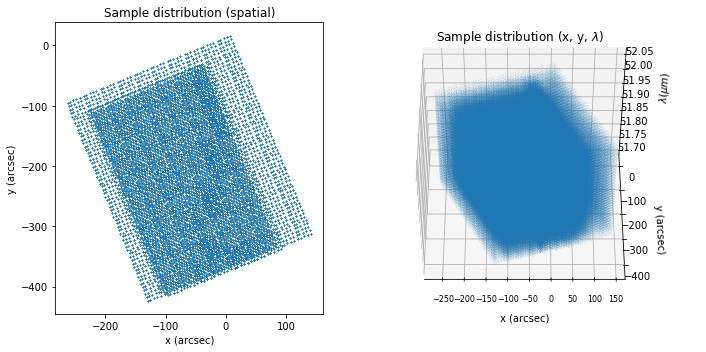

In [68]:
fig = plt.figure(figsize=(10,5), tight_layout=True)
ax1 = fig.add_subplot(121)
ax1.scatter(*coordinates[:2], marker='.', s=0.1, alpha=0.5)
ax1.set_xlabel('x (arcsec)')
ax1.set_ylabel('y (arcsec)')
ax1.set_aspect('equal')
ax1.set_title("Sample distribution (spatial)")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*coordinates, marker='.', s=0.1, alpha=0.5)
ax2.view_init(azim=270, elev=50)
# ax2.set_xlim(-30, 50)
# ax2.set_ylim(-110, 110)
ax2.set_xlabel('\nx (arcsec)', linespacing=1)
ax2.set_ylabel('\n\ny (arcsec)', linespacing=-1.5)
ax2.set_zlabel('\n' + r'$\lambda (\mu m)$', linespacing=3)
# ax2.dist = 10
ax2.set_title(r"Sample distribution (x, y, $\lambda$)", fontsize=12)

for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(8) 

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_30DOR_sample_distribution.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


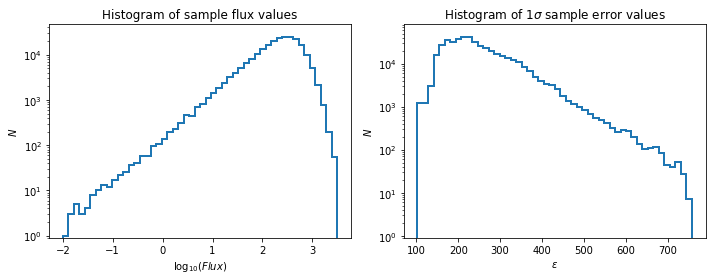

In [36]:
#plt.plot(error.ravel(), '.')
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
e = error.copy()
e = e[e > 0]
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax[0].hist(np.log10(data.ravel()), bins=50, histtype='step', log=True, range=[-2,3.5], lw=2)
    ax[0].set_xlabel(r"$\log_{10}(Flux)$")
    ax[0].set_ylabel(r"$N$")
    ax[0].set_ylim(0.9, None)
    ax[0].set_title(r"Histogram of sample flux values")
    ax[1].hist(10 ** np.log10(e.ravel()), bins=50, histtype='step', log=True, lw=2) # range=[0.5, 1.75]
    ax[1].set_xlabel(r"$\epsilon$")
    ax[1].set_ylabel(r"$N$")
    ax[1].set_title(r"Histogram of $1\sigma$ sample error values")
    ax[1].set_ylim(0.9, None)
    
plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_30DOR_sample_errors.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

In [69]:
r2 = Resample(coordinates, data, error=error, order=2, window=window * 5 / 3)

In [71]:
gx = grid[0]
# gx = gx[(gx >= xlim[0]) & (gx <= xlim[1])]
gy = grid[1] # [20:-20]
# gy = gy[(gy >= ylim[0]) & (gy <= ylim[1])]
gw = grid[2]
# gw = gw[(gw >= wlim[0]) & (gw <= wlim[1])]
wc = grid[2][20]

import time
t1 = time.time()
fit2, counts, chi2_2 = r2(gx, gy, wc, smoothing=smoothing, edge_threshold=edge_threshold,
                          get_counts=True, get_rchi2=True, jobs=-2)
t2 = time.time()
print("Standard done")
print("t=", t2 - t1)

t3 = time.time()
fit2_shape, chi2_2sh = r2(gx, gy, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
aw_shaped = r2.fit_settings['adaptive_alpha'].copy()
print('Shaped done')
t4 = time.time()
print('t=', t4-t3)

t5 = time.time()
fit2_scale, chi2_2sc = r2(gx, gy, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='scaled', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("Scaled done")
t6 = time.time()
print('t=', t6-t5)

t7 = time.time()
fit2_all, chi2_2all = r2(gx, gy, wc, smoothing=[xy_sigma, xy_sigma, w_sigma],
                 adaptive_threshold=[1,1,1], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("All done")
t8 = time.time()
print('t=', t8-t7)

aw_scaled = r2.fit_settings['adaptive_alpha'].copy()
print("Scaled done")

Standard done
t= 11.55020809173584
Shaped done
t= 86.80440878868103
Scaled done
t= 75.44887781143188
All done
t= 91.25230693817139
Scaled done


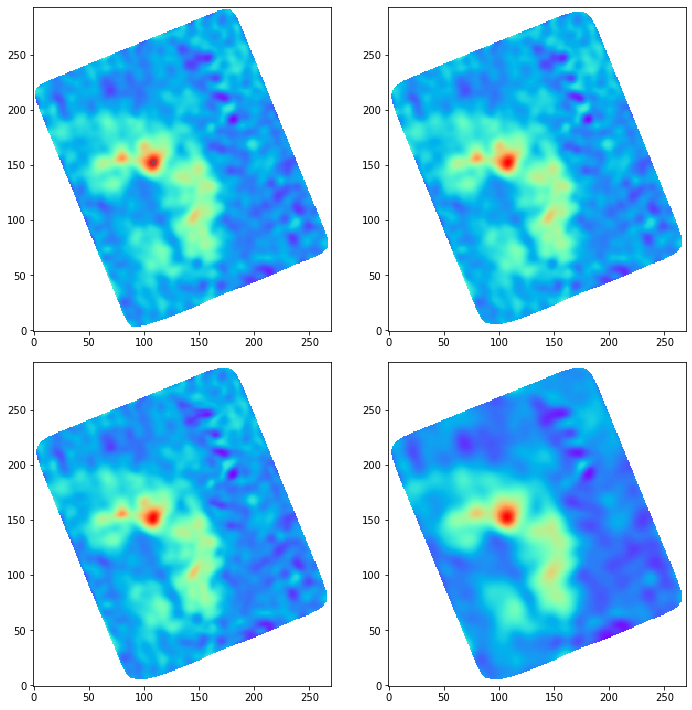

In [141]:
fig, ax = plt.subplots(2, 2, tight_layout=False, figsize=(10, 10))
fig.tight_layout(pad=1.0)
cmap='rainbow'
ax[0, 0].imshow(fit2[0], cmap=cmap, origin='lower')
ax[0, 1].imshow(fit2_scale[0], cmap=cmap, origin='lower')
ax[1, 0].imshow(fit2_shape[0], cmap=cmap, origin='lower')
ax[1, 1].imshow(fit2_all[0], cmap=cmap, origin='lower')

peak = np.array([108, 153, 20])
peak_coordinates = grid[0][peak[0]], grid[1][peak[1]], grid[2][peak[2]]
dx = xy_fwhm / 4
dw = w_fwhm / 4
gxyw = np.mgrid[:grid[0].size, :grid[1].size, :grid[2].size]
select_x = (coordinates[0] >= (peak_coordinates[0] - dx)) & (coordinates[0] <= (peak_coordinates[0] + dx))
select_y = (coordinates[1] >= (peak_coordinates[1] - dy)) & (coordinates[1] <= (peak_coordinates[1] + dy))
select_w = (coordinates[2] >= (peak_coordinates[2] - dw)) & (coordinates[2] <= (peak_coordinates[2] + dw))

ax[0, 0].plot(108, 153, 'x')

In [160]:
x, y, w = coordinates
xc, yc, wc = peak_coordinates
select_x = (y < (yc + dy)) & (y > (yc - dy))
select_x &= (w < (wc + dw)) & (w > (wc - dw))
# select_x &= np.abs(x) <= 50
x_out = np.linspace(x[select_x].min(), x[select_x].max(), 1000)

In [161]:


xfit, xchi2 = r2(x_out, yc, wc, smoothing=smoothing, edge_threshold=edge_threshold,
                    get_rchi2=True, jobs=-2)
print("Standard done")

xfit_shape, xchi2_sh = r2(x_out, yc, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print('Shaped done')

xfit_scale, xchi2_sc = r2(x_out, yc, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='scaled', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("Scaled done")


xfit_all, xchi2_all = r2(x_out, yc, wc, smoothing=[xy_sigma, xy_sigma, w_sigma],
                 adaptive_threshold=[1,1,1], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("All done")


Standard done
Shaped done
Scaled done
All done


In [162]:
aw_x = r2.fit_settings['adaptive_alpha'][:, 0, 0]
aw_x.shape
inverse_alpha_x = aw_x[:, 0]
alpha_x = 1 / inverse_alpha_x
scaled_sigma_x = ((0.5 * alpha_x * window[0]) ** 0.5)
max_sigma_x = np.nanmax(scaled_sigma_x)
min_sigma_x = np.nanmin(scaled_sigma_x)
print(min_sigma_x, max_sigma_x)

0.5753097726438595 3.260120334145669


In [205]:
select_y = (x < (xc + dx)) & (x > (xc - dx))
select_y &= (w < (wc + dw)) & (w > (wc - dw))
y_out = np.linspace(y[select_y].min(), y[select_y].max(), 1000)

In [206]:
yfit, ychi2 = r2(xc, y_out, wc, smoothing=smoothing, edge_threshold=edge_threshold,
                    get_rchi2=True, jobs=-2)
print("Standard done")

yfit_shape, ychi2_sh = r2(xc, y_out, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print('Shaped done')

yfit_scale, ychi2_sc = r2(xc, y_out, wc, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='scaled', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("Scaled done")


yfit_all, ychi2_all = r2(xc, y_out, wc, smoothing=[xy_sigma, xy_sigma, w_sigma],
                 adaptive_threshold=[1,1,1], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("All done")


Standard done
Shaped done
Scaled done
All done


In [207]:
aw_y = r2.fit_settings['adaptive_alpha'][:, 0, 0]
aw_y.shape
keep = ~np.isnan(aw_y[:, 0])
inverse_alpha_y = aw_y[keep, 1]

alpha_y = 1 / inverse_alpha_y
scaled_sigma_y = ((0.5 * alpha_y * window[1]) ** 0.5)
max_sigma_y = np.nanmax(scaled_sigma_y)
min_sigma_y = np.nanmin(scaled_sigma_y)
print(min_sigma_y, max_sigma_y)

0.851091449886602 433.9641923553633


/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [208]:
select_w = (x < (xc + dx)) & (x > (xc - dx))
select_w &= (y < (yc + dy)) & (y > (yc - dy))
w_out = np.linspace(w[select_w].min(), w[select_w].max(), 1000)

In [209]:
wfit, wchi2 = r2(xc, yc, w_out, smoothing=smoothing, edge_threshold=edge_threshold,
                    get_rchi2=True, jobs=-2)
print("Standard done")

wfit_shape, wchi2_sh = r2(xc, yc, w_out, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print('Shaped done')

wfit_scale, wchi2_sc = r2(xc, yc, w_out, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='scaled', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("Scaled done")


wfit_all, wchi2_all = r2(xc, yc, w_out, smoothing=[xy_sigma, xy_sigma, w_sigma],
                 adaptive_threshold=[1,1,1], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("All done")

Standard done
Shaped done
Scaled done
All done


In [210]:
aw_w = r2.fit_settings['adaptive_alpha'][:, 0, 0]
aw_w.shape
keep = ~np.isnan(aw_w[:, 0])
inverse_alpha_w = aw_w[keep, 2]

alpha_w = 1 / inverse_alpha_w
scaled_sigma_w = ((0.5 * alpha_w * window[2]) ** 0.5)
max_sigma_w = np.nanmax(scaled_sigma_w)
min_sigma_w = np.nanmin(scaled_sigma_w)
print(min_sigma_w, max_sigma_w)

0.05080032066973834 24.866002793773955


/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


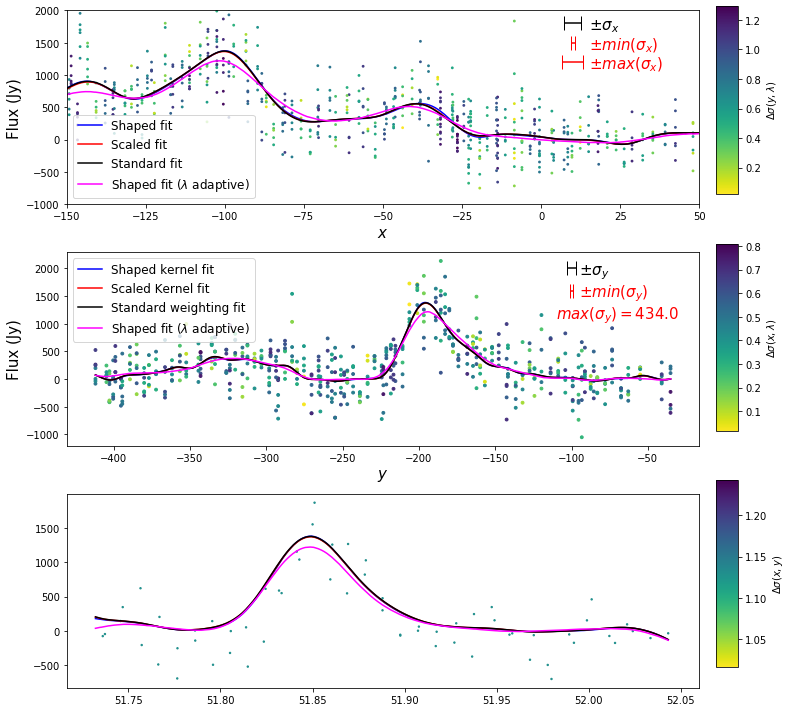

In [211]:
fig, ax = plt.subplots(3, 1, tight_layout=True, figsize=(10, 10))
from matplotlib import cm

# ax[0].plot(x[select_x], data[select_x], '.', markersize=3, label='Sample Measurements', cmap=cmap)
rx = np.hypot((y[select_x] - yc) / xy_sigma, (w[select_x] - wc) / w_sigma)

colx = ax[0].scatter(x[select_x], data[select_x], ec=None, s=8, cmap=cm.viridis_r, c=rx, vmax=rx.max(), vmin=rx.min())
cbar_ax = fig.add_axes([1.0, 0.725, 0.03, 0.26])
fig.colorbar(colx, cax=cbar_ax, label=r'${\Delta \sigma}(y,\lambda)$')
ax[0].plot(x_out, xfit_shape.ravel(), label='Shaped fit', color='b')
ax[0].plot(x_out, xfit_scale.ravel(), label='Scaled fit', color='r')
ax[0].plot(x_out, xfit.ravel(), label='Standard fit', color='k')
ax[0].plot(x_out, xfit_all.ravel(), label=r'Shaped fit ($\lambda$ adaptive)', color='magenta')

ax[0].set_xlabel(r"$x$", fontsize=15)
ax[0].set_ylabel(r"Flux (Jy)", fontsize=15)

ax[0].errorbar(10, 1800, xerr=xy_sigma, capsize=7, color='k')
ax[0].annotate(r'$\pm \sigma_{x}$', [15, 1700], xytext=[15, 1700], fontsize=15)

ax[0].errorbar(10, 1500, xerr=min_sigma_x, capsize=7, color='r')
ax[0].annotate(r'$\pm min(\sigma_{x})$', [15, 1400], xytext=[15, 1400], fontsize=15, color='r')

ax[0].errorbar(10, 1200, xerr=max_sigma_x, capsize=7, color='r')
ax[0].annotate(r'$\pm max(\sigma_{x})$', [15, 1100], xytext=[15, 1100], fontsize=15, color='r')

ax[0].legend(fontsize=12, loc='lower left')
ax[0].set_ylim(-1000, 2000)
ax[0].set_xlim(-150, 50)

# Y
ry = np.hypot((x[select_y] - xc) / xy_sigma, (w[select_y] - wc) / w_sigma)
coly = ax[1].scatter(y[select_y], data[select_y], s=8, cmap=cm.viridis_r, c=ry, vmin=ry.min(), vmax=ry.max())
cbar_ax_y = fig.add_axes([1.0, 0.395, 0.03, 0.26])
fig.colorbar(coly, cax=cbar_ax_y, label=r'${\Delta \sigma}(x,\lambda)$')
ax[1].plot(y_out, yfit_shape.ravel(), label='Shaped kernel fit', color='b')
ax[1].plot(y_out, yfit_scale.ravel(), label='Scaled Kernel fit', color='r')
ax[1].plot(y_out, yfit.ravel(), label='Standard weighting fit', color='k')
ax[1].plot(y_out, yfit_all.ravel(), label=r'Shaped fit ($\lambda$ adaptive)', color='magenta')

ax[1].set_xlabel(r"$y$", fontsize=15)
ax[1].set_ylabel(r"Flux (Jy)", fontsize=15)

ax[1].errorbar(-100, 2000, xerr=xy_sigma, capsize=7, color='k')
ax[1].annotate(r'$\pm \sigma_{y}$', [-95, 1900], xytext=[-95, 1900], fontsize=15)

ax[1].errorbar(-100, 1600, xerr=min_sigma_y, capsize=7, color='r')
ax[1].annotate(r'$\pm min(\sigma_{y})$', [-95, 1500], xytext=[-95, 1500], fontsize=15, color='r')

# ax[1].errorbar(-100, 1200, xerr=max_sigma_y, capsize=7, color='r')
ax[1].annotate(r'$max(\sigma_{y})=%.1f$' % max_sigma_y, [-110, 1100], xytext=[-110, 1100], fontsize=15, color='r')

ax[1].legend(fontsize=12, loc='upper left')

# Lambda
rw = np.hypot((x[select_w] - xc) / xy_sigma, (y[select_w] - yc) / xy_sigma)
colw = ax[2].scatter(w[select_w], data[select_w], s=2, cmap=cm.viridis_r, c=rw, label='Samples', vmin=rw.min(), vmax=rw.max())
cbar_ax_w = fig.add_axes([1.0, 0.067, 0.03, 0.26])
fig.colorbar(colw, cax=cbar_ax_w, label=r'${\Delta \sigma}(x,y)$')

ax[2].plot(w_out, wfit_shape.ravel(), label='Shaped kernel fit', color='b')
ax[2].plot(w_out, wfit_scale.ravel(), label='Scaled Kernel fit', color='r')
ax[2].plot(w_out, wfit.ravel(), label='Standard weighting fit', color='k')
ax[2].plot(w_out, wfit_all.ravel(), label=r'Shaped fit ($\lambda$ adaptive)', color='magenta')


# ax[2].set_xlabel(r"$\lambda$", fontsize=15)
# ax[2].set_ylabel(r"Flux (Jy)", fontsize=15)
# ax[2].errorbar(158.2, 350, xerr=w_sigma, capsize=7, color='k')
# ax[2].annotate(r'$\pm \sigma_{\lambda}$', [158.2, 400], xytext=[158.17, 400], fontsize=15)
# # ax.annotate(r"$\Delta\lambda \approx %.2f\,/\, fwhm_{\lambda}$" % sampling_w, [157.27, 800], fontsize=12)
# ax[2].legend(fontsize=12, loc='upper left')


# plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_M82_cross_sections.png',
#             bbox_inches='tight', pad_inches=0.1)
# plt.show()

7.230854206285723
8.700274479762506
79380
1203.0


(0.9, 4193.2911113729915)

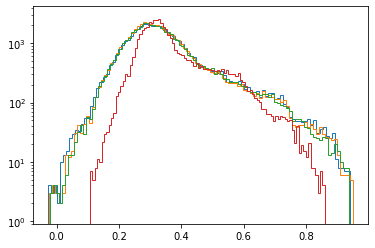

In [134]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.hist(np.log10(chi2_2.ravel()), bins=100, histtype='step', density=False, log=True)
    plt.hist(np.log10(chi2_2sc.ravel()), bins=100, histtype='step', density=False, log=True)
    plt.hist(np.log10(chi2_2sh.ravel()), bins=100, histtype='step', density=False, log=True)
    plt.hist(np.log10(chi2_2all.ravel()), bins=100, histtype='step', density=False, log=True)
    
print(np.nanmax(chi2_2all))
print(np.nanmax(chi2_2))
print(chi2_2.size)
print(np.nanmedian(counts))
plt.ylim(0.9, None)

In [82]:
print(wc)
print(fit2.shape)
for g in grid:
    print(g.shape)

51.8468241275437
(1, 294, 270)
(270,)
(294,)
(50,)


Comparison of IDL and Python

In [83]:
hdul_idl = fits.open(idl_wxy_file)
hdul = fits.open(py_wxy_file)

In [212]:
hdul[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  327                                                  
NAXIS2  =                  356                                                  
NAXIS3  =                   50                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
DATE-OBS= '2016-06-28T10:16:57' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =               2000.0 / Coordinate equinox                             
CTYPE1  = 'RA---TAN'           / Axis 1 type and projection                     
CTYPE2  = 'DEC--TAN'        

In [213]:
hdul_idl[1].header

XTENSION= 'IMAGE   '           /extension type                                  
BITPIX  =                  -64 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                  327 /                                                
NAXIS2  =                  356 /                                                
NAXIS3  =                   49 /                                                
PCOUNT  =                    0 /                                                
GCOUNT  =                    1 /                                                
EXTNAME = 'FLUX    '           /                                                
DATE-OBS= '2016-06-28T10:16:57' / Observation date                              
BUNIT   = 'Jy/pixel'           / Data units                                     
EQUINOX =              2000.00 / Coordinate equinox                             
CTYPE1  = 'RA---TAN'        

/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/dperera/opt/anaconda3/envs/dev2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


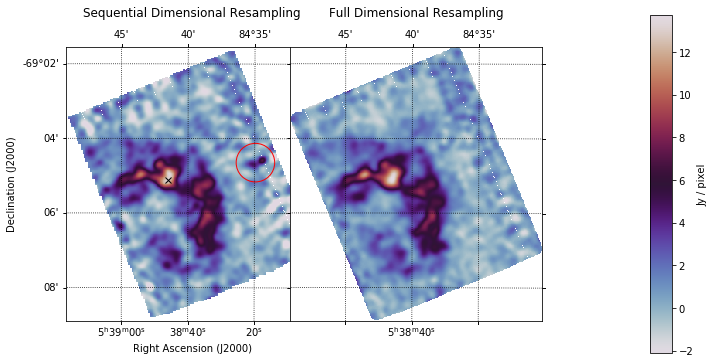

In [471]:
data = hdul[1].data.copy()
data_idl = hdul_idl[1].data.copy()
error = hdul[2].data.copy()
error_idl = hdul_idl[2].data.copy()
data.shape
from astropy.wcs import WCS
import astropy.units as u

cmap = 'rainbow'
cmap = 'twilight'

vmin = np.nanmin(data[21])
vmax = np.nanmax(data[21])

fig = plt.figure(figsize=(10,5), tight_layout=True)
fig.tight_layout(pad=0.0)

wcs_idl = WCS(hdul_idl[1].header)
ax1 = fig.add_subplot(121, projection=wcs_idl, slices=('x', 'y', 21))
ax1.coords[2].set_ticklabel(exclude_overlapping=True)
im = ax1.imshow(data_idl[21, :, :], cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
ax1.plot(cx, cy, 'x', color='k')

overlay1 = ax1.get_coords_overlay('fk5')
overlay1.grid(color='black', ls='dotted')
overlay1[0].set_axislabel(' ')
overlay1[1].set_axislabel(' ')

wcs = WCS(hdul[1].header)
ax2 = fig.add_subplot(122, projection=wcs, slices=('x', 'y', 21))
ax2.coords[2].set_ticklabel(exclude_overlapping=True)
ax2.imshow(data[21, :, :], cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)

overlay2 = ax2.get_coords_overlay('fk5')
overlay2.grid(color='black', ls='dotted')
overlay2[0].set_axislabel(' ')
overlay2[1].set_axislabel(' ')

lon1 = ax1.coords[0]
lat1 = ax1.coords[1]
lon2 = ax2.coords[0]
lat2 = ax2.coords[1]

lon2.set_ticks(spacing=10 * u.arcmin, color='white')
lat2.set_ticks(spacing=10 * u.arcmin, color='white')
lon2.set_ticklabel(exclude_overlapping=True)
lat2.set_ticklabel(exclude_overlapping=True)

ax1.coords[0].set_ticks(color='white')
ax1.coords[1].set_ticks(color='white')
ax1.coords['ra'].set_axislabel('Right Ascension (J2000)')
ax1.coords['dec'].set_axislabel('Declination (J2000)')

ax2.coords[0].set_ticks(color='white')
ax2.coords[1].set_ticks(color='white')
ax2.coords['ra'].set_axislabel(' ')
ax2.coords['dec'].set_axislabel(' ')
overlay1[1].set_ticklabel_visible(False)
overlay2[1].set_ticklabel_visible(False)

ax1.set_title("Sequential Dimensional Resampling", pad=30)
ax2.set_title("Full Dimensional Resampling", pad=30)

# fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.98, 0.03, 0.03, 0.94])
fig.colorbar(im, cax=cbar_ax, label='Jy / pixel')

wi = 21
xy_slice = data[21]
mxy = np.nanargmax(xy_slice)
ny, nx = xy_slice.shape
gy, gx = np.mgrid[:ny, :nx]
ra, dec, w0 = wcs.wcs_pix2world(gx, gy, 21, 0)
maxd = np.nonzero(data == np.nanmax(data))
cw, cy, cx = maxd
lx, ly = 130, 250
# ax1.plot(lx, ly, 'x', color='k')

artifact_xy = np.array([243, 203])

artifact = plt.Circle((245, 205), radius=25.0, color='r', fill=False, linestyle='-', lw=1)
# ax.add_patch(window)
ax1.add_patch(artifact)


plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_30DOR_image_comparison.png',
            bbox_inches='tight', pad_inches=0.05)
plt.show()


In [420]:
data.shape

(50, 356, 327)

In [322]:
# hdul_idl[0].header

In [406]:
# hdul[0].header

-193.77930797399313

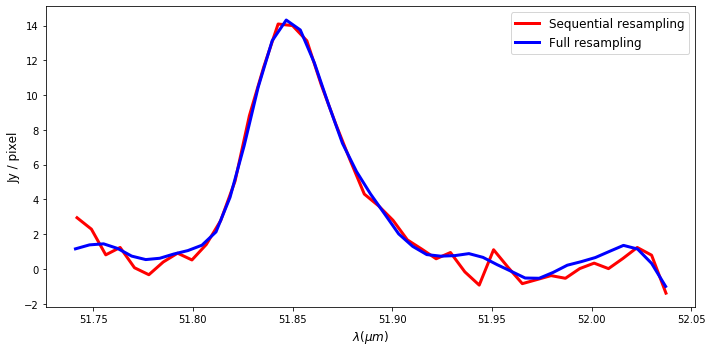

In [442]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(10, 5))

cx = int(cx)
cy = int(cy)

e = error[:, cy, cx] * 3
e_idl = error_idl[:, cy, cx] * 3
d = data[:, cy, cx]
d_idl = data_idl[:, cy, cx]


_, _, w_idl = wcs_idl.wcs_pix2world(cx, cy, np.arange(data_idl.shape[0]), 0)
w_idl *= 1e6
ax.plot(w_idl, d_idl, label="Sequential resampling", lw=3, color='r')
# ax.fill_between(w_idl, d_idl+e_idl, d_idl-e_idl, alpha=0.2, color='r', label=r'f(x) $\pm \sigma_{f(x)}$')

_, _, w = wcs.wcs_pix2world(cx, cy, np.arange(data.shape[0]), 0)
w *= 1e6
ax.plot(w[5:-2], d[5:-2], label='Full resampling', lw=3, color='b')
# ax.fill_between(w, d+e, d-e, alpha=0.2, color='b', label=r'f(x) $\pm \sigma_{f(x)}$')

ax.set_xlabel(r"$\lambda (\mu m)$", fontsize=12)
ax.set_ylabel(r"Jy / pixel", fontsize=12)

ax.legend(fontsize=12)

# _, _, wl_idl = wcs_idl.wcs_pix2world(lx, ly, np.arange(data_idl.shape[0]), 0)
# ax[1].plot(w_idl, data_idl[:, ly, lx])

# _, _, wl = wcs.wcs_pix2world(lx, ly, np.arange(data.shape[0]), 0)
# ax[1].plot(w, data[:, ly, lx])

plt.savefig('/Users/dperera/mmoc_repo/pypeutils/docs/sofia_redux/toolkit/resampling/paper/images/fifi_30DOR_line_comparison.png',
            bbox_inches='tight', pad_inches=0.05)
plt.show()


In [467]:
from astropy.coordinates import Angle, SkyCoord
ra, dec, w0 = wcs.wcs_pix2world(gx, gy, 21, 0)
ra = ra[cy, cx] * u.deg
dec = dec[cy, cx] * u.deg
c = SkyCoord(ra, dec)
print(c.ra.to_string(u.hour))
print(c.dec.to_string(u.degree))


['5h38m45.9046s']
['-69d05m06.2397s']


In [ ]:
import time
t1 = time.time()
fita, counta, chi2a = r2(gx, gy, gw, smoothing=smoothing, edge_threshold=edge_threshold,
                          get_counts=True, get_rchi2=True, jobs=-2)
t2 = time.time()
print("Standard done")
print("t=", t2 - t1)

t3 = time.time()
fita_shape, chi2a_2sh = r2(gx, gy, gw, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
aw_shaped = r2.fit_settings['adaptive_alpha'].copy()
print('Shaped done')
t4 = time.time()
print('t=', t4-t3)

t5 = time.time()
fit2a_scale, chi2a_2sc = r2(gx, gy, gw, smoothing=[xy_sigma, xy_sigma, smoothing[2]],
                 adaptive_threshold=[1,1,0], adaptive_algorithm='scaled', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("Scaled done")
t6 = time.time()
print('t=', t6-t5)

t7 = time.time()
fit2a_all, chi2a_2all = r2(gx, gy, gw, smoothing=[xy_sigma, xy_sigma, w_sigma],
                 adaptive_threshold=[1,1,1], adaptive_algorithm='shaped', get_rchi2=True,
                 edge_threshold=edge_threshold, jobs=-2)
print("All done")
t8 = time.time()
print('t=', t8-t7)

In [ ]:
plt.plot()